# Lesson 2: 基于Pytorch的手写数字识别

手写数字识别是经典的图像分类课题，在CNN网络出现之前，手写数字识别最高达到99.65%（6层全链接网络），非神经网络则通常低于95%，波动极大。而在CNN网络之后，识别准确率就基本大于99%，7层CNN网络的准确率则已较大幅度超过之前的99.65% （http://yann.lecun.com/exdb/mnist/）。

尽管手写数字识别已不是当前图像分类领域的主要问题，但其数据集小巧，能够快速训练，快速验证，在今天仍然是图像算法模型预研的基础工具之一。下面我们用Pytorch来实现基于Mnist的数字识别。

首先引入相关依赖


In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

然后定义网络结构，在Pytorch中，定义网络结构则等同于定义前向算法，Pytorch会自动处理对应的反向传播实现

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    # 【conv1, relu, conv2, relu, max_pool, dropout, fc1, dropout, fc2, softmax] 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


然后定义模型训练过程：

In [4]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

每批次模型训练完成后（每个epoch之后），我们可以调用test方法进行验证：

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

上面定义了卷积网络模型Net、训练方法train、测试方法test，基本工作就完成了，剩下则需要定义一些训练参数（俗称调参），开始训练：

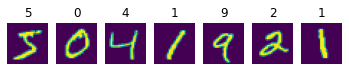

In [6]:

import matplotlib.pyplot as plt
import numpy as np

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) 
        ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(dataset1[i][0].view(28,28))
    ax[i].set_title(dataset1[i][1])
    ax[i].axis('off')

import io
import base64
my_stringIObytes = io.BytesIO()
plt.savefig(my_stringIObytes, format='jpg')
my_stringIObytes.seek(0)
my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
jpgStr = my_base64_jpgData.decode("utf-8")

import requests
url = 'https://pdumhe-ahmwgf-5000.app.myide.io/image'
myobj = {'image_data': jpgStr}
x = requests.post(url, json = myobj)

In [7]:
def start_trainning():
    # 基本参数
    device = "cpu"
    seed = 1.0
    epochs = 2
    learning_rate = 1.0
    lr_decay_gamma = 0.7

    torch.manual_seed(seed)

    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}

    # normalize images with mean 0.1307 and std 0.3081
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) 
        ])

    # 读取数据集，dataset1是训练数据，dataset2是测试数据
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    # 初始化模型、optimizer等训练属性
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay_gamma)

    # 开始训练
    for epoch in range(1, epochs):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    # 保存模型
    torch.save(model, "mnist_cnn.pt")

现在你可以选择下面代码，执行start_training() 开始训练。 你也可以在命令行执行`python test.py`

In [8]:
start_trainning()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305400
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.359776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.842884
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.587047
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.368678
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.468111
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.264334
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.288218
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.588464
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.225416
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.248743
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.346687
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.194711
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.223726
